<a href="https://colab.research.google.com/github/peisuke/homography-estimation/blob/main/homography_ex5_LoFTR_CONSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Configure environment and grab LoFTR code.
!pip install torch einops yacs kornia
!pip install python-box
!git clone https://github.com/zju3dv/LoFTR

     |████████████████████████████████| 493 kB 34.7 MB/s 
     |████████████████████████████████| 3.0 MB 11.5 MB/s 
Cloning into 'LoFTR'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 396 (delta 5), reused 2 (delta 0), pack-reused 381
Receiving objects: 100% (396/396), 30.85 MiB | 41.78 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
!git clone --recurse-submodules https://github.com/fkluger/consac.git

Cloning into 'consac'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 106 (delta 51), reused 70 (delta 21), pack-reused 0
Receiving objects: 100% (106/106), 7.90 MiB | 36.45 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Submodule 'datasets/nyu_vp' (https://github.com/fkluger/nyu_vp.git) registered for path 'datasets/nyu_vp'
Submodule 'datasets/yud_plus' (https://github.com/fkluger/yud_plus.git) registered for path 'datasets/yud_plus'
Cloning into '/content/consac/datasets/nyu_vp'...
remote: Enumerating objects: 4393, done.        
remote: Counting objects: 100% (17/17), done.        
remote: Compressing objects: 100% (14/14), done.        
remote: Total 4393 (delta 7), reused 9 (delta 3), pack-reused 4376        
Receiving objects: 100% (4393/4393), 50.11 MiB | 27.21 MiB/s, done.
Resolving deltas: 100% (1153/1153), done.
Cloning into '/content/consac/datasets/yud_plus'...
remo

In [ ]:
!mkdir weights 
!cd weights && gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY
To: /content/weights/outdoor_ds.ckpt
100% 46.3M/46.3M [00:00<00:00, 72.1MB/s]


In [ ]:
import sys
sys.path.append('./consac')
sys.path.append('./LoFTR')

In [ ]:
import torch
import glob
import random
import cv2
import numpy as np
from box import Box
from PIL import Image
from src.loftr import LoFTR, default_cfg

In [ ]:
from util.misc import *
from util.cn_net import CNNet
from util import sampling
from util.em_algorithm import em_for_homographies, em_for_vp
from util.evaluation import calc_labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/colab_data/pair_images.zip .
!unzip -q pair_images.zip

In [ ]:
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [ ]:
opt = Box()
opt.seed = 1
opt.ckpt = 'consac/models/consac-s_homography.net'
opt.img1 = 'consac/demo/img1.jpg'
opt.img2 = 'consac/demo/img2.jpg'
opt.threshold = 0.0001
opt.threshold2 = 0.0002
opt.inlier_cutoff = 20
opt.hyps = 100
opt.outerhyps = 100
opt.instances = 3
opt.em = 10
opt.cpu = False
opt.unconditional = False

In [ ]:
torch.manual_seed(opt.seed)
np.random.seed(opt.seed)
random.seed(opt.seed)

device = torch.device('cuda' if torch.cuda.is_available() and not opt.cpu else 'cpu', 0)

ddim = 5
batch_norm = False
model = CNNet(6, ddim, batch_norm=batch_norm)
model = model.to(device)

In [ ]:
def match(img0_raw, img1_raw):
    if len(img0_raw.shape) > 2:
        img0_raw = cv2.cvtColor(img0_raw, cv2.COLOR_BGR2GRAY)
    if len(img1_raw.shape) > 2:
        img1_raw = cv2.cvtColor(img1_raw, cv2.COLOR_BGR2GRAY)

    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
    batch = {'image0': img0, 'image1': img1}

    # Inference with LoFTR and get prediction
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()

    kp0 = [cv2.KeyPoint(p[0], p[1], 1) for p in mkpts0]
    kp1 = [cv2.KeyPoint(p[0], p[1], 1) for p in mkpts1]
    good = [cv2.DMatch(i, i, 1) for i in range(len(mkpts0))]

    return kp0, kp1, good

In [ ]:
def get_homography_features_for_demo(kp1, kp2, good, shape1, shape2, opt):
    M = max([shape1[0], shape2[0]])
    N = shape1[1] + shape2[1]

    data = np.zeros((len(good), 4), dtype=np.float32)
    data_unscaled = np.zeros((len(good), 4))
    img_width = shape1[1]
    img_height = shape1[0]
    scale = np.maximum(img_width, img_height)/2
    for idx, match in enumerate(good):
        idx1 = match.queryIdx
        idx2 = match.trainIdx
        p1 = [(kp1[idx1].pt[0]-img_width/2)/scale,
              (kp1[idx1].pt[1]-img_height/2)/scale]
        p2 = [(kp2[idx2].pt[0]-img_width/2)/scale,
              (kp2[idx2].pt[1]-img_height/2)/scale]

        data[idx, 0] = p1[0]
        data[idx, 1] = p1[1]
        data[idx, 2] = p2[0]
        data[idx, 3] = p2[1]

        p1 = [(kp1[idx1].pt[0]),
              (kp1[idx1].pt[1])]
        p2 = [(kp2[idx2].pt[0]),
              (kp2[idx2].pt[1])]

        data_unscaled[idx, 0] = p1[0]
        data_unscaled[idx, 1] = p1[1]
        data_unscaled[idx, 2] = p2[0]
        data_unscaled[idx, 3] = p2[1]

    return data, data_unscaled

In [ ]:
def find_inlier(kp1, kp2, good, shape1, shape2, model, opt):
    data, data_unscaled = get_homography_features_for_demo(kp1, kp2, good, shape1, shape2, opt)

    model_dim = 9
    uniform_sampling = False
    model_gen_fun = sampling.homographies_from_points_parallel
    consistency_fun = sampling.homographies_consistency_measure_parallel_2dim
    min_set_size = 4
    em_fun = em_for_homographies

    inlier_fun1 = sampling.soft_inlier_fun_gen(5. / opt.threshold, opt.threshold)

    all_losses = []

    data = torch.from_numpy(data).unsqueeze(0)
    B = data.size(0)
    Y = data.size(1)
    masks = torch.ones((B,Y), device=device)
    data = data.to(device)
    masks = masks.to(device)

    M = opt.instances
    P = opt.outerhyps
    S = opt.hyps

    with torch.no_grad():
        all_inliers = torch.zeros((P, M, S, Y), device=device)
        all_probs = torch.zeros((P, M, Y), device=device)
        all_best_inliers = torch.zeros((P, M, Y), device=device)
        all_best_inlier_counts = torch.zeros(P, device=device)
        all_best_hypos = torch.zeros((P, M,), device=device, dtype=torch.long)
        all_models = torch.zeros((P, M, S, model_dim), device=device)
        all_best_models = torch.zeros((P, M, model_dim), device=device)

        data_and_state = torch.zeros((P, Y, ddim),
                                    device=device)
        for oh in range(P):
            data_and_state[oh, :, 0:(ddim - 1)] = data[0, :, 0:(ddim - 1)]

        uniform_probs = torch.ones((P, Y), device=device)

        inliers_so_far = torch.zeros((P, Y), device=device)

        for mi in range(M):

            if uniform_sampling:
                probs = uniform_probs
            else:
                data = data.to(device)
                log_probs = model(data_and_state)
                probs = torch.softmax(log_probs[:, 0, 0:Y, 0], dim=-1)

            all_probs[:, mi, :Y] = probs

            cur_probs = probs.view(P, 1, 1, Y).expand((P, S, 1, Y))
            models, inliers, choices, distances = \
                sampling.sample_model_pool_multiple_parallel(data[0], Y, min_set_size, inlier_fun1, model_gen_fun,
                                                            consistency_fun, cur_probs, device=device,
                                                            model_size=model_dim, sample_count=S)
            all_inliers[:, mi, :, 0:Y] = inliers.squeeze()[:, 0:Y]
            all_models[:, mi, :] = models.squeeze()

            for oh in range(P):

                all_inliers_so_far = torch.max(all_inliers[oh, mi], inliers_so_far[oh])
                all_inlier_counts_so_far = torch.sum(all_inliers_so_far, dim=-1)

                best_hypo = torch.argmax(all_inlier_counts_so_far)
                all_best_hypos[oh, mi] = best_hypo
                all_best_models[oh, mi] = models[oh].squeeze()[best_hypo]

                if not opt.unconditional:
                    data_and_state[oh, 0:Y, (ddim - 1)] = torch.max(
                        all_inliers[oh, mi, best_hypo, 0:Y],
                        data_and_state[oh, 0:Y, (ddim - 1)])
                else:
                    uniform_probs[oh] = torch.min(uniform_probs[oh], 1 - all_inliers[oh, mi, best_hypo, 0:Y])

                inliers_so_far[oh] = all_inliers_so_far[best_hypo]

        for oh in range(P):
            inlier_list = []
            for mi in range(M):
                best_hypo = all_best_hypos[oh, mi]
                inliers = all_inliers[oh, mi, best_hypo]
                inlier_list += [inliers]

            best_inliers = torch.stack(inlier_list, dim=0)

            joint_inliers = torch.zeros(best_inliers.size(), device=device)
            joint_inliers[0] = best_inliers[0]
            for mi in range(1, M):
                joint_inliers[mi] = torch.max(joint_inliers[mi - 1], best_inliers[mi])
            cumulative_inlier_counts = torch.sum(joint_inliers, dim=-1)
            average_cumulative_inlier_count = torch.mean(cumulative_inlier_counts)

            all_best_inliers[oh] = best_inliers
            best_inliers, best_inlier_idx = torch.max(best_inliers, dim=0)
            best_inlier_count = torch.sum(best_inliers)
            all_best_inlier_counts[oh] = average_cumulative_inlier_count

        best_outer_hypo = torch.argmax(all_best_inlier_counts)

    best_models = all_best_models[best_outer_hypo]

    if opt.em > 0:
        best_models_ = best_models.view(1, best_models.size(0), best_models.size(1))

        refined_models, posterior, variances, _ = em_fun(data, best_models_, masks.to(torch.float),
                                                                    iterations=opt.em, init_variance=1e-9,
                                                                    device=device)
        refined_models.squeeze_(0)
        posterior.squeeze_(0)

    else:
        refined_models = best_models

    refined_inliers = torch.zeros((M, Y))
    refined_distances = torch.zeros((M, Y))

    for mi in range(M):
        inliers = all_best_inliers[best_outer_hypo, mi]
        inlier_indices = torch.nonzero(inliers)
        if opt.em:
            new_model = refined_models[mi]
            new_model *= torch.sign(new_model[-1])
        else:
            new_model = best_models[mi]

        refined_models[mi] = new_model
        new_distances = sampling.homography_consistency_measure(new_model, data[0], device)
        new_inliers = sampling.soft_inlier_fun(new_distances, 5. / (opt.threshold2), opt.threshold2)
        refined_inliers[mi] = new_inliers

    last_inlier_count = 0
    selected_instances = 0
    joint_inliers = torch.zeros((Y,))
    for mi in range(M):
        joint_inliers = torch.max(joint_inliers, refined_inliers[mi, :])
        inlier_count = torch.sum(joint_inliers, dim=-1)
        new_inliers = inlier_count - last_inlier_count
        last_inlier_count = inlier_count
        print("instance %d: %.2f additional inliers" % (mi, new_inliers))
        selected_instances += 1
        if new_inliers < opt.inlier_cutoff:
            break
    estm_models = []
    for mi in range(selected_instances):
        estm_models += [refined_models[mi].cpu().numpy()]
    estm_models = np.vstack(estm_models)
    estm_labels = calc_labels(data[0], selected_instances, estm_models, opt.threshold2)

    best_probs = all_probs[best_outer_hypo]
    inliers = np.max(all_best_inliers[best_outer_hypo, 0:(mi + 1)].cpu().numpy(), axis=0)

    inliers /= np.max(inliers)
    probsort = np.argsort(inliers)

    pts1 = data_unscaled[:, 0:2]
    pts2 = data_unscaled[:, 2:4]
    
    kp0 = []
    kp1 = []
    for di_ in range(pts1.shape[0]):
        di = probsort[di_]
        inlier = inliers[di]
        if inlier > 0:
            kp0.append(cv2.KeyPoint(pts1[di, 0], pts1[di, 1], 1))
            kp1.append(cv2.KeyPoint(pts2[di, 0], pts2[di, 1], 1))
    good = [cv2.DMatch(i, i, 1) for i in range(len(kp0))]

    return kp0, kp1, good

./LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
./LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


instance 0: 3011.29 additional inliers
instance 1: 14.40 additional inliers


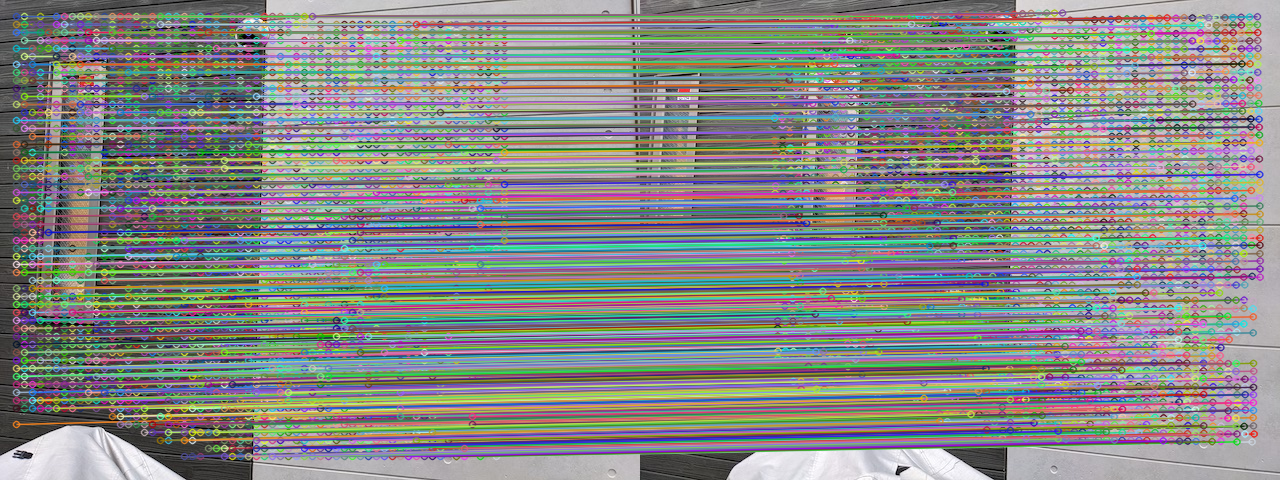

In [ ]:
files = sorted(glob.glob('pair_images/pair_01/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
kp1, kp2, good2 = find_inlier(kp1, kp2, good, img1.shape, img2.shape, model, opt)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

./LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
./LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


instance 0: 2608.08 additional inliers
instance 1: 5.25 additional inliers


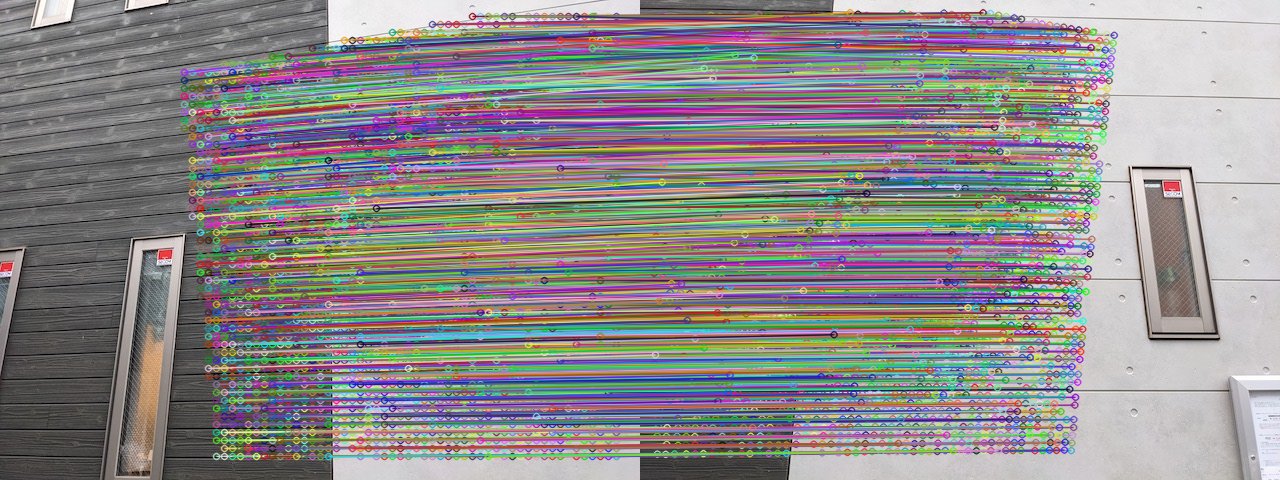

In [ ]:
files = sorted(glob.glob('pair_images/pair_02/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
kp1, kp2, good2 = find_inlier(kp1, kp2, good, img1.shape, img2.shape, model, opt)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

./LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
./LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


instance 0: 734.47 additional inliers
instance 1: 615.66 additional inliers
instance 2: 88.22 additional inliers


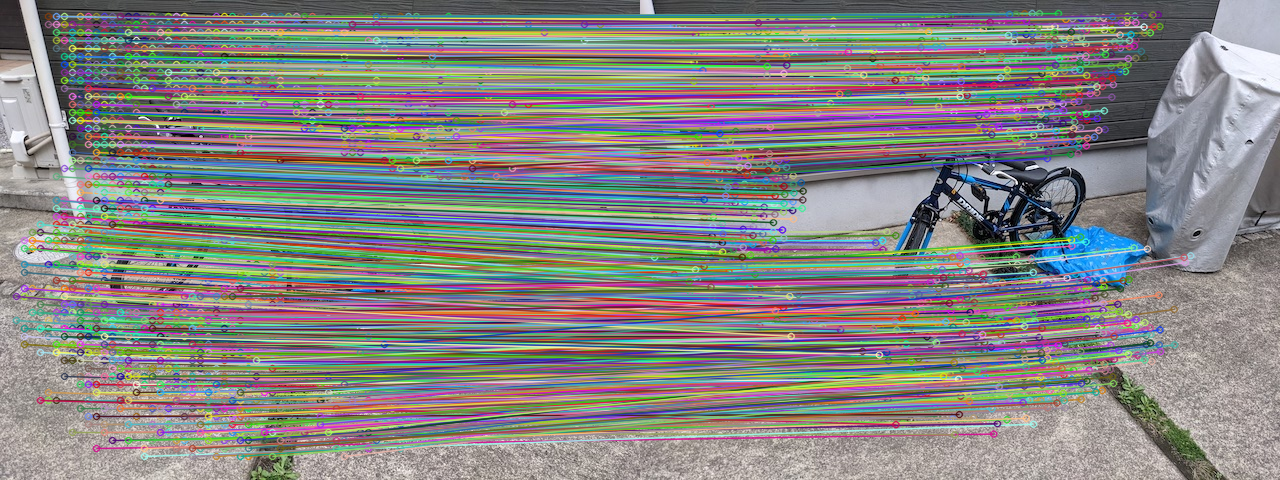

In [ ]:
files = sorted(glob.glob('pair_images/pair_03/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
kp1, kp2, good2 = find_inlier(kp1, kp2, good, img1.shape, img2.shape, model, opt)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

./LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
./LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


instance 0: 85.98 additional inliers
instance 1: 37.35 additional inliers
instance 2: 24.64 additional inliers


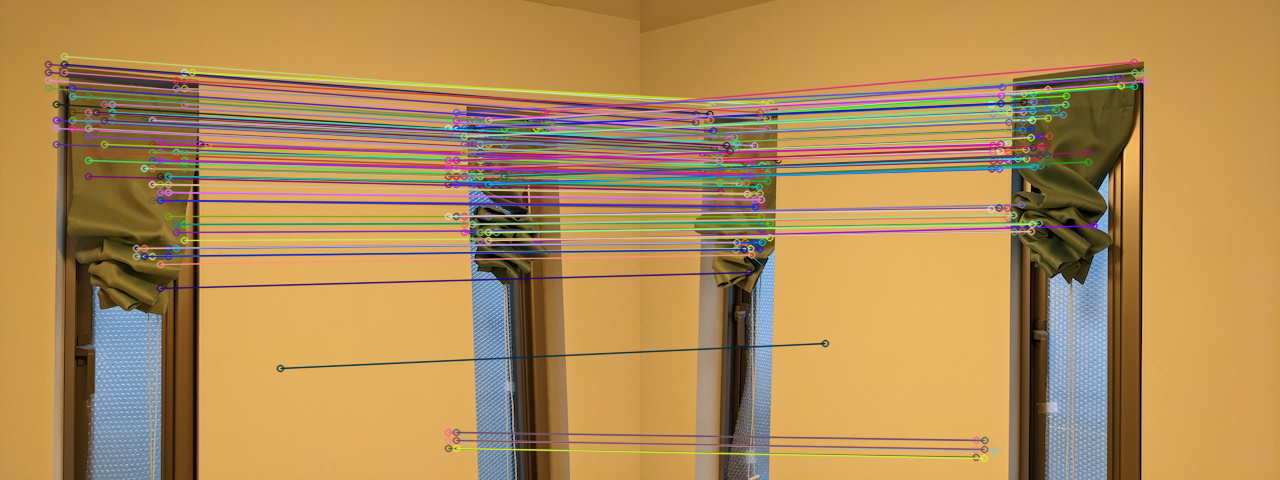

In [ ]:
files = sorted(glob.glob('pair_images/pair_04/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
kp1, kp2, good2 = find_inlier(kp1, kp2, good, img1.shape, img2.shape, model, opt)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

./LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
./LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


instance 0: 2118.99 additional inliers
instance 1: 124.16 additional inliers
instance 2: 29.64 additional inliers


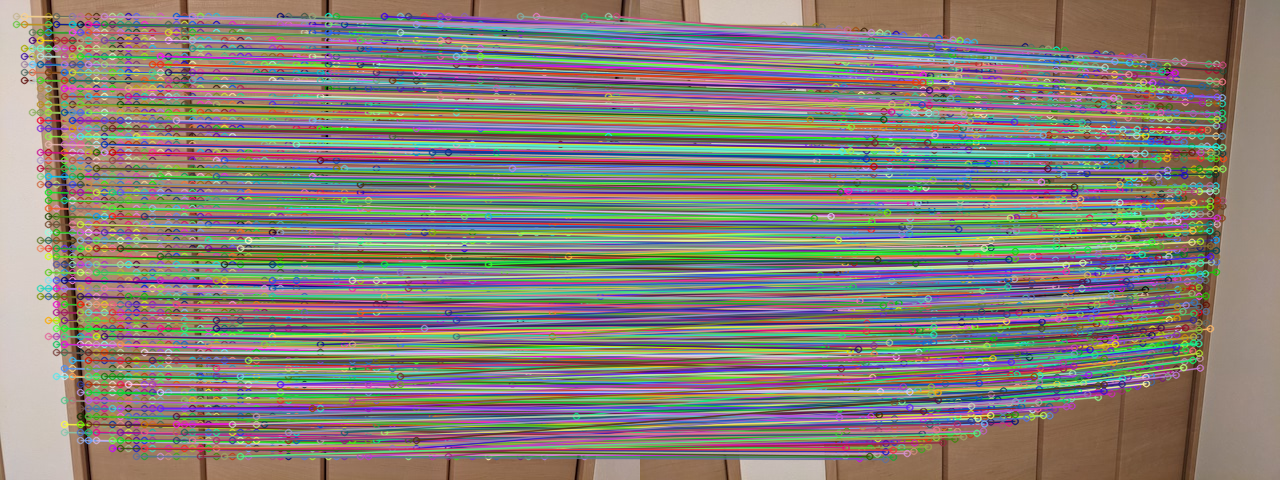

In [ ]:
files = sorted(glob.glob('pair_images/pair_05/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
kp1, kp2, good2 = find_inlier(kp1, kp2, good, img1.shape, img2.shape, model, opt)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

./LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
./LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


instance 0: 24.75 additional inliers
instance 1: 19.38 additional inliers


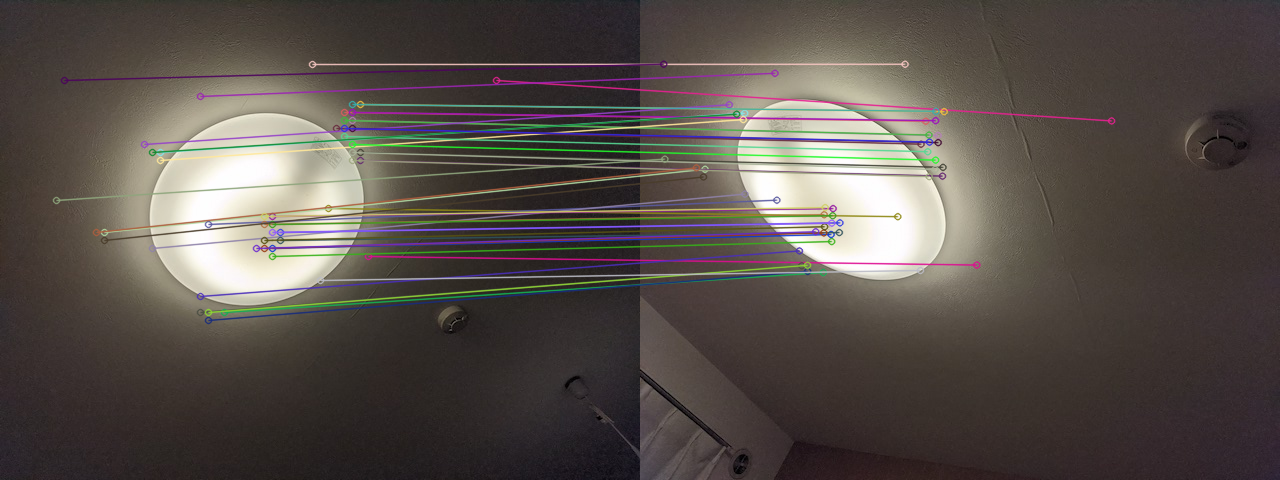

In [ ]:
files = sorted(glob.glob('pair_images/pair_06/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
kp1, kp2, good2 = find_inlier(kp1, kp2, good, img1.shape, img2.shape, model, opt)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

./LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
./LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


instance 0: 864.44 additional inliers
instance 1: 32.96 additional inliers
instance 2: 10.88 additional inliers


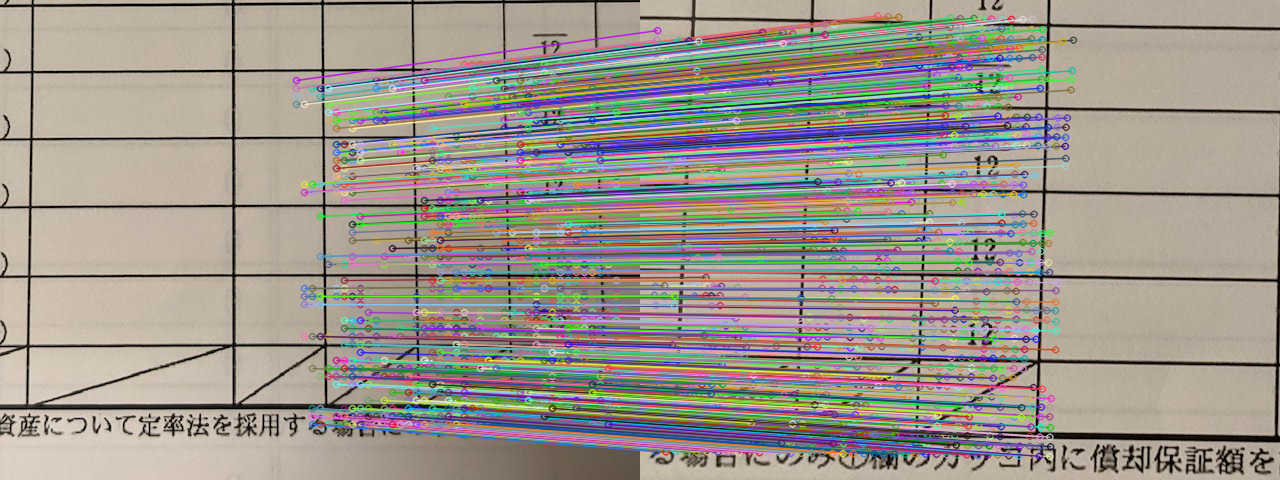

In [ ]:
files = sorted(glob.glob('pair_images/pair_07/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
kp1, kp2, good2 = find_inlier(kp1, kp2, good, img1.shape, img2.shape, model, opt)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))